## Business forecasting final project

In [25]:
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlforecast import MLForecast
from mlforecast.lag_transforms import Combine, RollingMean
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

## Part 1. Data preparation

### 1. Reading data, rename column, check missing data, transform to date time

In [26]:
#Loading data
future_values = pd.read_csv('future_values.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id'})
metadata = pd.read_csv('metadata.csv').rename(columns={'store_id':'unique_id'})
sales_data = pd.read_csv('sales_data.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id','sales':'y'})
sales_data.dtypes

/var/folders/gm/_yp4_bjn6l7dvvpx97_5_c0c0000gn/T/ipykernel_58048/3612097706.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_data = pd.read_csv('sales_data.csv',parse_dates = ['date']).rename(columns={'date':'ds','store_id':'unique_id','sales':'y'})


unique_id                 object
ds                datetime64[ns]
y                          int64
customers                  int64
open                       int64
promo                      int64
state_holiday             object
school_holiday             int64
dtype: object

In [27]:
#Checking implicitly missing values

# Grouping data by each time series
grouped = sales_data.groupby('unique_id')

print("\nDate range per unique_id:")
date_range = sales_data.groupby('unique_id')['ds'].agg(['min', 'max', 'count'])
print(date_range)

# Creating a summary dataframe for visualizing data completeness
summary = grouped.agg(
    count_observed=('ds', 'count'),
    start_date=('ds', 'min'),
    end_date=('ds', 'max')
).reset_index()

summary['expected_count'] = (
    (summary['end_date'].dt.to_period('M') - summary['start_date'].dt.to_period('M')).apply(lambda x: x.n) + 1
)

# Identifying which time series are irregular
summary['is_irregular'] = summary['count_observed'] < summary['expected_count']

filtered = summary[summary['is_irregular'] == True]
display(filtered)


Date range per unique_id:
                 min        max  count
unique_id                             
store_1   2013-01-07 2015-07-19    924
store_10  2013-01-07 2015-07-19    924
store_100 2013-01-07 2015-07-19    924
store_101 2013-01-07 2015-07-19    924
store_102 2013-01-07 2015-07-19    924
...              ...        ...    ...
store_95  2013-01-07 2015-07-19    924
store_96  2013-01-07 2015-07-19    924
store_97  2013-01-07 2015-07-19    924
store_98  2013-01-07 2015-07-19    924
store_99  2013-01-07 2015-07-19    924

[676 rows x 3 columns]


,unique_id,count_observed,start_date,end_date,expected_count,is_irregular


##### As the result shows an empty df, there is no implicitly missing date

In [28]:
# Grouping data by each time series
grouped = future_values.groupby('unique_id')
summary = grouped.agg(
    count_observed=('ds', 'count'),
    start_date=('ds', 'min'),
    end_date=('ds', 'max')
).reset_index()
print(summary)

     unique_id  count_observed start_date   end_date
0      store_1              60 2015-07-20 2015-09-17
1     store_10              60 2015-07-20 2015-09-17
2    store_100              60 2015-07-20 2015-09-17
3    store_101              60 2015-07-20 2015-09-17
4    store_102              60 2015-07-20 2015-09-17
..         ...             ...        ...        ...
671   store_95              60 2015-07-20 2015-09-17
672   store_96              60 2015-07-20 2015-09-17
673   store_97              60 2015-07-20 2015-09-17
674   store_98              60 2015-07-20 2015-09-17
675   store_99              60 2015-07-20 2015-09-17

[676 rows x 4 columns]


In [29]:
#Checking NA
future_values.isna ().sum ()
metadata.isna ().sum ()
sales_data.isna().sum()

unique_id         0
ds                0
y                 0
customers         0
open              0
promo             0
state_holiday     0
school_holiday    0
dtype: int64

##### There is no explicitly missing value

### 2. Merge the 'metadata' with 'sales_data' and 'future_values'

In [30]:
sales_merged = pd.merge(sales_data, metadata, on='unique_id', how='left')
future_merged = pd.merge(future_values, metadata, on='unique_id', how='left')
sales_merged.head()

,unique_id,ds,y,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance
0,store_1,2015-07-19,0,0,0,0,0,0,c,a,1270.0
1,store_2,2015-07-19,0,0,0,0,0,0,a,a,14130.0
2,store_3,2015-07-19,0,0,0,0,0,0,a,c,24000.0
3,store_4,2015-07-19,0,0,0,0,0,0,a,a,7520.0
4,store_5,2015-07-19,0,0,0,0,0,0,a,c,2030.0


### 3. Transform to weekly data, because the company is interested in weekly forecast to make the plan for weekly inventory and staffing

In [31]:
# Create a weekly bucket
sales_merged['week'] = sales_merged['ds'].dt.to_period('W-MON').dt.start_time

# Make sure state_holiday is string type
sales_merged['state_holiday'] = sales_merged['state_holiday'].astype(str)

# Count how many times each state_holiday type appears per week per store
holiday_counts = (
    sales_merged
    .groupby(['unique_id', 'week', 'state_holiday'])
    .size()
    .unstack(fill_value=0)  # turns into columns
    .reset_index()
    .rename_axis(None, axis=1)  # remove column name
)

# Optional: Rename columns for clarity
holiday_counts.columns = ['unique_id', 'week'] + [f'state_holiday_{col}' for col in holiday_counts.columns[2:]]

# Now aggregate your normal weekly data
weekly_data = sales_merged.groupby(['unique_id', 'week'], as_index=False).agg({
    'y': 'sum',
    'customers': 'sum',
    'promo': 'sum',
    'open': 'sum',
    'school_holiday': 'sum',
    'store_type': 'first',
    'assortment': 'first',
    'competition_distance': 'first'
})

# Merge the holiday counts in
weekly_data = weekly_data.merge(holiday_counts, on=['unique_id', 'week'], how='left')

# Fill in 0 where a holiday type didn’t occur that week
weekly_data.fillna(0, inplace=True)

weekly_data= weekly_data.rename(columns={'week':'ds'})
weekly_data

,unique_id,ds,y,customers,promo,open,school_holiday,store_type,assortment,competition_distance,state_holiday_0,state_holiday_a,state_holiday_b,state_holiday_c
0,store_1,2013-01-01,7176,785,1,1,1,c,a,1270.0,1,0,0,0
1,store_1,2013-01-08,30493,3749,4,6,4,c,a,1270.0,7,0,0,0
2,store_1,2013-01-15,26655,3408,1,6,0,c,a,1270.0,7,0,0,0
3,store_1,2013-01-22,31732,3804,4,6,0,c,a,1270.0,7,0,0,0
4,store_1,2013-01-29,31670,3774,1,6,0,c,a,1270.0,7,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89903,store_99,2015-06-16,51761,5071,4,6,0,a,a,2640.0,7,0,0,0
89904,store_99,2015-06-23,48696,4871,1,6,1,a,a,2640.0,7,0,0,0
89905,store_99,2015-06-30,55631,5181,4,6,5,a,a,2640.0,7,0,0,0
89906,store_99,2015-07-07,44007,4350,1,6,5,a,a,2640.0,7,0,0,0


## Part 2. Exploratory Data Analysis

### Analyze trends, seasonality, holidays, promotion, and store type impact

In [32]:
def compute_seasonality_strength(df):
    results = []

    for uid, group in df.groupby('unique_id'):
        # 确保按时间顺序排列
        group = group.sort_values('ds')

        # 提取目标值
        y = group['y'].values

        # 以“周”作为季节单位，提取 week number (1-52)
        group['week_of_year'] = group['ds'].dt.isocalendar().week

        # 计算每个 week_of_year 的平均值（即“季节成分”）
        seasonal_means = group.groupby('week_of_year')['y'].transform('mean')

        # 残差 = y - 季节均值
        residual = y - seasonal_means.values

        # 强度计算
        var_y = np.var(y)
        var_resid = np.var(residual)
        strength = max(0, 1 - var_resid / var_y) if var_y > 0 else 0

        # 写入结果
        group['seasonality'] = strength
        results.append(group[['unique_id', 'ds', 'seasonality']])

        # 拼接前先删除旧的 seasonality 列（如存在）
        df = df.drop(columns=['seasonality'], errors='ignore')

    # 合并所有 unique_id 的结果
    return pd.merge(df, pd.concat(results), on=['unique_id', 'ds'], how='left')

# 应用函数
weekly_data = compute_seasonality_strength(weekly_data)

# 创建 features 表：每个 unique_id 只保留一行（避免重复）
features = weekly_data[[
    'unique_id', 'seasonality', 'store_type', 'assortment', 'competition_distance'
]].drop_duplicates(subset='unique_id').reset_index(drop=True)

features

,unique_id,seasonality,store_type,assortment,competition_distance
0,store_1,0.761202,c,a,1270.0
1,store_10,0.755376,d,c,4110.0
2,store_100,0.631947,c,a,4130.0
3,store_101,0.770614,a,a,3770.0
4,store_102,0.740095,a,c,480.0
...,...,...,...,...,...
671,store_95,0.810593,a,c,100.0
672,store_96,0.807218,a,a,12540.0
673,store_97,0.417402,d,a,980.0
674,store_98,0.638690,a,a,1070.0


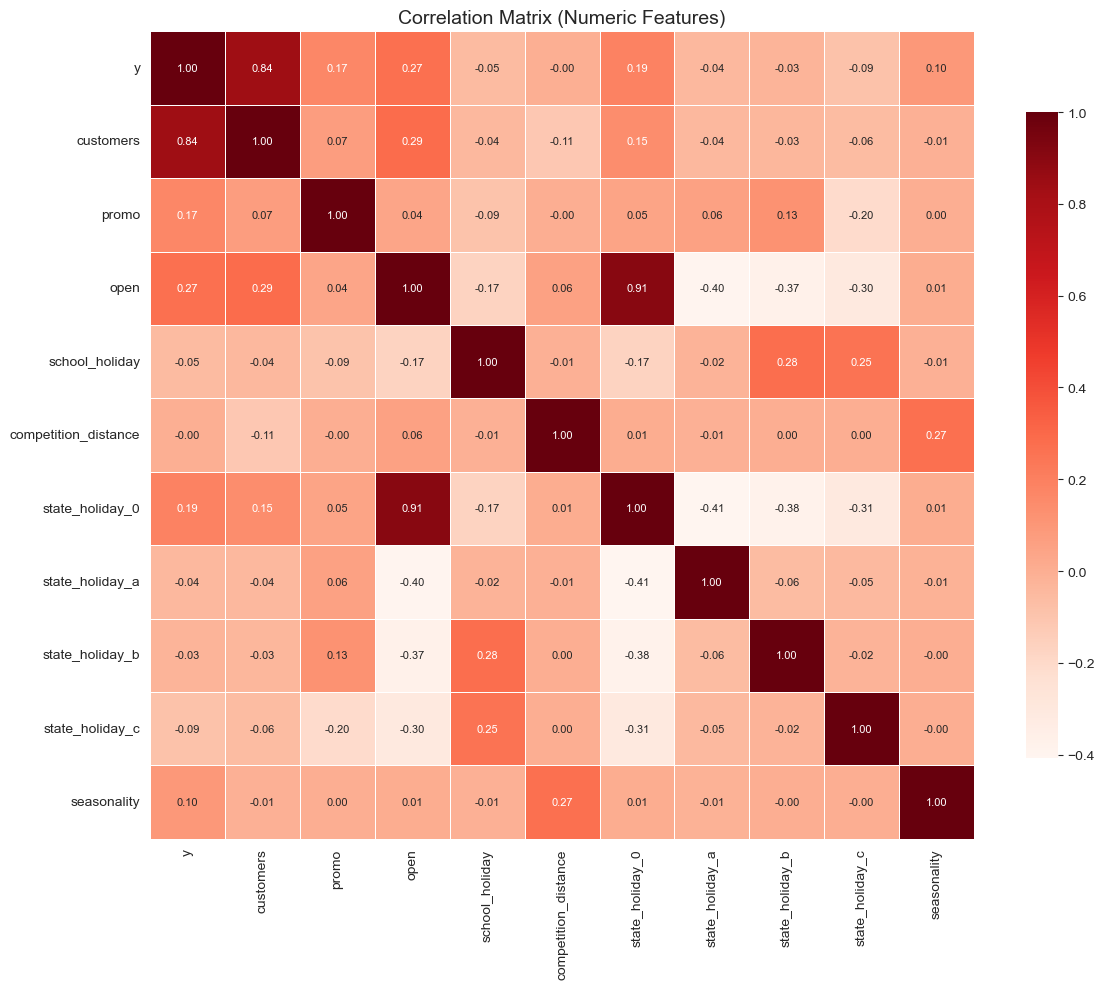

In [33]:
#correlation plot

# 计算相关矩阵
co_mtx = weekly_data.corr(numeric_only=True)

# 设置图像大小
plt.figure(figsize=(12, 10))

# 绘制热力图，使用红色系（"Reds"），注释字体更小，线更细
sns.heatmap(
    co_mtx,
    cmap="Reds",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8},
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'shrink': 0.8}
)

# 设置标题（可选）
plt.title("Correlation Matrix (Numeric Features)", fontsize=14)

# 防止标签重叠
plt.tight_layout()

# 显示图像
plt.show()

##### We have used ChatGPT to improve the correlation matrix format.

In [34]:
# def add_lags(weekly_data, lags):
#     for lag in lags:
#         weekly_data[f"lag_{lag}"] = weekly_data.groupby("unique_id")["y"].shift(lag)
#     return weekly_data
#
# # 添加滞后特征
# weekly_data = add_lags(weekly_data, lags=[1, 2, 4, 13, 52])
#
# # 只删除所有 lag 特征中包含 NaN 的行
# lag_cols = [f"lag_{lag}" for lag in [1, 2, 4, 13, 52]]
# weekly_data.dropna(subset=lag_cols, inplace=True)
# weekly_data

In [35]:
# # Step 1: Extract lag columns
# lag_cols = [col for col in weekly_data.columns if col.startswith("lag_")]
#
# # Step 2: Extract numeric feature columns (excluding id, week, y, and lag columns)
# excluded_cols = ['unique_id', 'week', 'y'] + lag_cols
# feature_cols = [col for col in weekly_data.columns
#                 if col not in excluded_cols and pd.api.types.is_numeric_dtype(weekly_data[col])]
#
# # Step 3: Initialize correlation matrix
# correlation_matrix = pd.DataFrame(index=feature_cols, columns=lag_cols, dtype=float)
#
# # Step 4: Compute correlation if both columns have variance and are not all-NaN
# for feature in feature_cols:
#     for lag in lag_cols:
#         x = weekly_data[feature]
#         y = weekly_data[lag]
#         # 检查是否有有效值和非恒定值
#         if x.nunique(dropna=True) > 1 and y.nunique(dropna=True) > 1:
#             correlation = x.corr(y)
#         else:
#             correlation = np.nan  # 无法计算相关性
#         correlation_matrix.loc[feature, lag] = correlation
#
# # Step 5: Drop rows/cols with all NaN
# correlation_matrix.dropna(how='all', axis=0, inplace=True)
# correlation_matrix.dropna(how='all', axis=1, inplace=True)
#
# # Step 6: Plot heatmap
# plt.figure(figsize=(12, 8))  # 放大图表
# sns.heatmap(correlation_matrix, annot=True, cmap="Reds", center=0,
#             fmt=".2f", annot_kws={"size": 8})
# plt.title("Correlation between Lag Features and Other Predictors")
# plt.xlabel("Lag Features")
# plt.ylabel("Other Features")
# plt.tight_layout()
# plt.show()

#### think about: open, state_holiday 0,a,b,c???????

## Part 3. Best performing model selection

#### 1. Cross validation for Naive, RWD, Seasonal Naive, Holt-Winters, AutoARIMA,Random Forest, LSTM

### Naive, Seasonal Naive

## Part 4. Advanced Modeling